In [60]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

import concurrent.futures

import albumentations as A

In [2]:
clist = np.array([[255, 255, 255], [11, 60, 100], [162, 250, 163]])

In [3]:
def compute_errors(gt, pred, mask=None):
    """Computation of error metrics between predicted and ground truth depths
    """
    if mask is None:
        mask = np.ones_like(gt) == 1
        
    gt = gt[mask]
    pred = pred[mask]
        
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

In [5]:
def get_seg_map(depth, bev, K):
    baseline = 0.2
    cam_height = 1.0

    inv_K = np.linalg.inv(K[:3,:3])

    h, w = depth.shape

    img_rect = np.concatenate([np.indices((w, h)), np.ones((1, w, h))], axis=0)

    pc = (inv_K @ img_rect.reshape((3, -1))).reshape((3, w, h))
    pc = pc.transpose((0,2,1)) * depth
    pc = pc.reshape((3, -1))

    pc = np.concatenate([pc, np.ones((1, h*w))], axis=0)

    bev_size = (3.2, 3.2) # m
    bev_res = bev_size[0] / bev.shape[0]
    
    cam_to_agent = np.eye(4)

    T = np.zeros((4, 4))
    T[0,0] = 1
    T[1,2] = -1
    T[2,1] = 1
    T[3,3] = 1
    T[0,3] = 1.6
    T[1,3] = 3.2

    ortho_cam_points = (T @ cam_to_agent @ pc) // bev_res
    valid = (ortho_cam_points[0] >= 0) & (ortho_cam_points[0] < bev.shape[1]) & (ortho_cam_points[1] >= 0) & (ortho_cam_points[1] < bev.shape[0]) & (ortho_cam_points[2] >= 0)

    pt_bev_indices = (ortho_cam_points[1, valid]*bev.shape[1] + ortho_cam_points[0, valid]).astype(int)
    pt_bev_cls = np.take(bev.reshape(-1), pt_bev_indices)

    seg_map = np.zeros(w * h, dtype=np.uint8)
    seg_map[valid] = pt_bev_cls
    seg_map = seg_map.reshape((h, w))
    
    return seg_map

In [8]:
data_dir = '/scratch/shantanu/gibson4/new'
bev_dir = '/scratch/shantanu/gibson4/dilated_partialmaps'
semantic_dir = '/scratch/shantanu/gibson4/semantics'

print(os.listdir(data_dir))

['Pettigrew', 'Pablo', 'Hambleton', 'Elmira', 'Angiola', 'Stilwell', 'Rosser', 'Shelbiana', 'Capistrano', 'Hometown', 'Roxboro', 'Dunmor', 'Sisters', 'Eudora', 'Avonia', 'Arkansaw', 'Sanctuary', 'Bolton', 'Sumas', 'Convoy', 'Ribera', 'Silas', 'Delton', 'Superior', 'Monson', 'Rancocas', 'Stokes', 'Colebrook', 'Mifflintown', 'Hainesburg', 'Sargents', 'Crandon', 'Denmark', 'Pleasant', 'Roeville', 'Hillsdale', 'Adrian', 'Stanleyville', 'Albertville', 'Roane', 'Woonsocket', 'Hominy', 'Nicut', 'Nimmons', 'Nemacolin', 'Anaheim', 'Azusa', 'Swormville', 'Brevort', 'Haxtun', 'Sodaville', 'Spencerville', 'Soldier', 'Parole', 'Placida', 'Seward', 'Cantwell', 'Sawpit', 'Spotswood', 'Ballou', 'Nuevo', 'Dryville', 'Eagerville', 'Maryhill', 'Mobridge', 'Mosquito', 'Scioto', 'Edgemere', 'Goffs', 'Annawan', 'Eastville', 'Beach', 'Bowlus', 'Quantico', 'Oyens', 'Kerrtown', 'Applewold', 'Springhill', 'Scottsmoor', 'Andover', 'Micanopy', 'Reyno', 'Sands', 'Sasakwa', 'Mosinee', 'Mesic', 'Greigsville', 'Coope

In [9]:
def camera_intrinsic_transform(f_x, c_x, f_y, c_y):
    camera_intrinsics = np.zeros((3,4))
    camera_intrinsics[0][0] = f_x
    camera_intrinsics[1][1] = f_y
    camera_intrinsics[2][2] = 1
    camera_intrinsics[0][2] = c_x
    camera_intrinsics[1][2] = c_y
    
    return camera_intrinsics

In [53]:
import kornia.filters as ktf
import torch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0 127 254]


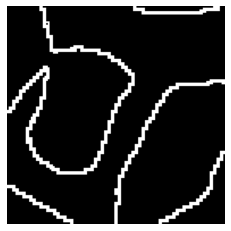

[  0 127 254]


(-0.5, 127.5, 127.5, -0.5)

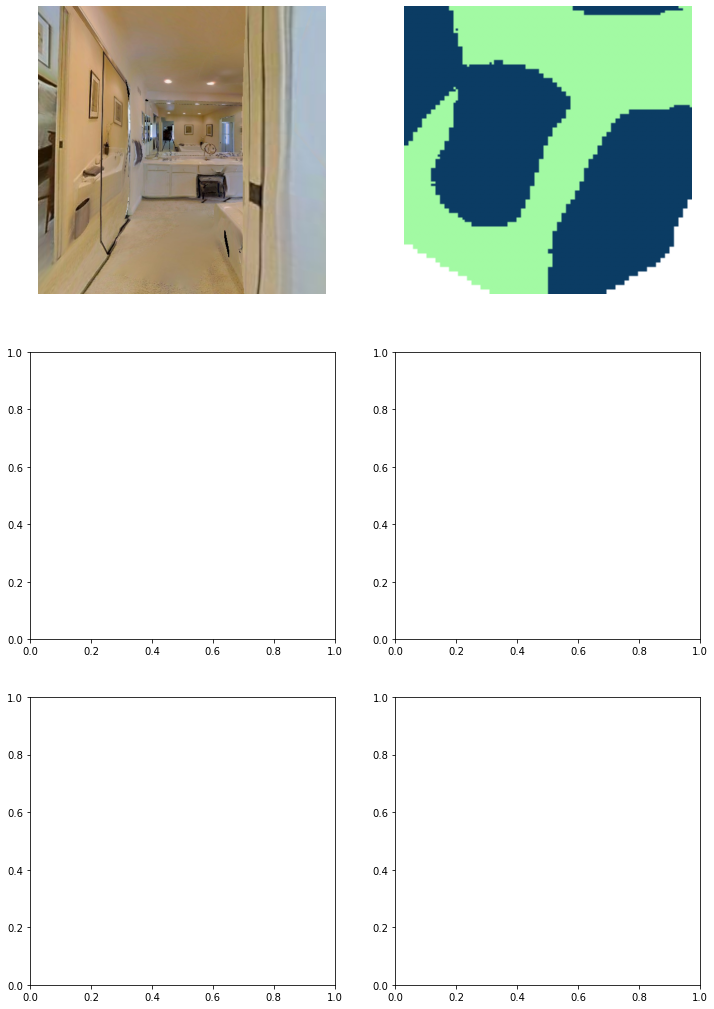

In [72]:
scene = 'Mosquito'
fileidx = 181
bev_shape = (64, 64)
img_shape = w,h = (512, 512)
floor_semantic_classes = [3, 28]

org_shape = (1024, 1024)

f = (org_shape[0] * h) / (2 * org_shape[1])

K = camera_intrinsic_transform(f_x=f, c_x=w/2, f_y=f, c_y=h/2)

rgb_fp = os.path.join(data_dir, scene, '0', 'front', 'RGB', f'{fileidx}.jpg')
depth_fp = os.path.join(data_dir, scene, '0', 'front', 'DEPTH', f'{fileidx}.png')
sem_fp = os.path.join(semantic_dir, scene, '0', 'front', 'semantics', f'{fileidx}.png')
partial_occ_fp = os.path.join(bev_dir, scene, '0', 'front', 'vo', f'{fileidx}.png')

# print(partial_occ_fp)
partial_occ_fp = '/scratch/shantanu/gibson4/visible_occupancy/Mosquito/0/front/vo/181.png'


bev_fp = os.path.join(data_dir, scene, '0', 'front', 'map', f'{fileidx}.png')

rgb = cv2.cvtColor(cv2.imread(rgb_fp, -1), cv2.COLOR_BGR2RGB)
depth = np.array(cv2.imread(depth_fp, -1)).astype(np.float32)/6553.5
sem = np.isin(cv2.imread(sem_fp, -1), floor_semantic_classes) * 1.0
partial_occ = cv2.imread(partial_occ_fp, -1)[64:, 32:96]
bev = cv2.imread(bev_fp, -1)[64:, 32:96]

width_ar = int(rgb.shape[1] * img_shape[0] / rgb.shape[0])
rgb = cv2.resize(rgb, dsize=(width_ar, img_shape[0]), interpolation=cv2.INTER_NEAREST)
rgb = rgb[:img_shape[0], (width_ar - img_shape[1])//2 : (width_ar + img_shape[1])//2]
depth = cv2.resize(depth, dsize=(width_ar, img_shape[0]), interpolation=cv2.INTER_NEAREST)
depth = depth[:img_shape[0], (width_ar - img_shape[1])//2 : (width_ar + img_shape[1])//2]
sem = cv2.resize(sem, dsize=(width_ar, img_shape[0]), interpolation=cv2.INTER_NEAREST)
sem = sem[:img_shape[0], (width_ar - img_shape[1])//2 : (width_ar + img_shape[1])//2]
partial_occ = cv2.resize(partial_occ, dsize=bev_shape, interpolation=cv2.INTER_NEAREST)
bev = cv2.resize(bev, dsize=bev_shape, interpolation=cv2.INTER_NEAREST)
bev = 255-bev

# if '0' in os.listdir(os.path.join(bev_dir, scene)):
#     subdir = os.path.join('0', os.listdir(os.path.join(bev_dir, scene, '0'))[0])
# else:
#     subdir = ''

# bev_subdir = '0/pred_bev'
# depth_subdir = '0/pred_depth'

# bev = cv2.imread(os.path.join(bev_dir, scene, bev_subdir, f'{idx}.png'), -1)
# bev = cv2.resize(bev, dsize=bev_tgtshape, interpolation=cv2.INTER_NEAREST)
# bev[0, 0] = 0

# pred_depth = cv2.imread(os.path.join(bev_dir, scene, depth_subdir, f'{idx}.png'), -1) / 6553.5
# pred_depth = cv2.resize(pred_depth, dsize=tgt_shape, interpolation=cv2.INTER_NEAREST)
# pred_depth = np.clip(pred_depth, a_min=0, a_max=10.0)

# depth_diff = depth - pred_depth

# mask = np.logical_and(seg, depth>0.1, depth<10.0)
# error_metrics = compute_errors(depth, pred_depth, mask)

# Use bev from simulator to create floor segmentation map
bev_seg = get_seg_map(depth, partial_occ, K)
print(np.unique(bev_seg))

# tgt_bev =  cv2.imread(f'/scratch/shantanu/HabitatGibson/bevs/partial_occupancy/{scene}/{idx}.png', -1)
# tgt_bev = cv2.resize(tgt_bev, dsize=bev_tgtshape, interpolation=cv2.INTER_NEAREST)

overlay = np.copy(rgb)
overlay[bev_seg==127, 0] *= 3
# overlay[bev_seg==255, 1] *= 3
overlay[bev_seg==0, 2] *= 3

# partial_occ = cv2.imread("/scratch/pavani/mp3d/mp3d_dilated_partialmaps/X7HyMhZNoso/front/partial_occ/367.png", -1)
partial_occ = cv2.imread("/scratch/shantanu/final_results/mp3d/weights_90/X7HyMhZNoso/front/367.png", -1)

# partial_occ = partial_occ[64:, 32:-32]
# partial_occ = cv2.imread(partial_occ_fp, -1)

spatial_gradient = ktf.spatial_gradient(torch.unsqueeze(torch.unsqueeze(torch.Tensor(partial_occ), dim=0), dim=0)).cpu().numpy()
boundary = np.linalg.norm(spatial_gradient, axis=2)
boundary[boundary > 0] = 1

# boundary = boundary[:, :, 64:, 32:-32]

boundary_rgb = np.zeros((128, 128, 3))
boundary_rgb[boundary[0, 0] == 1] = [255, 255, 255]

# print(boundary.shape)

# ret, thresh = cv2.threshold(partial_occ, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# a, contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

plt.imshow(boundary_rgb)
plt.axis('off')
plt.show()

partial_occ_rgb = np.zeros((128, 128, 3))
partial_occ_rgb[partial_occ == 0] = [255, 255, 255]
partial_occ_rgb[partial_occ == 127] = [11, 60, 100]
partial_occ_rgb[partial_occ == 254] = [162, 250, 163]

print(np.unique(partial_occ))

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(12, 18))
ax = axes.flatten()
ax[0].imshow(rgb)
ax[0].axis('off')
ax[1].imshow(partial_occ_rgb/255)
ax[1].axis('off')
# ax[1].imshow(depth_diff * seg)
# ax[1].text(20, 160, ' a1: {:.2f}\n a2: {:.2f}\n a3: {:.2f}\n'.format(*error_metrics[4:]), fontsize = 22)
# ax[2].imshow(tgt_bev)
# ax[3].imshow(bev)
# ax[4].imshow(get_seg_map(depth, tgt_bev))
# ax[5].imshow(bev_seg)

In [11]:
def save_video(scene):
    num_frames = len(os.listdir(os.path.join(data_dir, scene, '0', 'left_rgb')))
    fps = 3
    duration = num_frames / fps
    print(scene, duration)
    fig, axes = plt.subplots(ncols=5, figsize=(30, 6))

    def get_frame(t):
        for ax in axes:
            ax.clear()
            
        idx = int(t * fps)
        
        rgb = cv2.imread(os.path.join(data_dir, scene, '0', 'left_rgb', f'{idx}.jpg'), -1)
        seg = np.isin(cv2.imread(os.path.join(data_dir, scene, '0', 'left_semantic', f'{idx}.png'), -1), (3, 28)) * 1.0
        depth = cv2.imread(os.path.join(data_dir, scene, '0', 'left_depth', f'{idx}.png'), -1).astype(np.float32)/6553.5

        width_ar = int(depth.shape[1] * tgt_shape[0] / depth.shape[0])
        rgb = cv2.resize(rgb, dsize=(width_ar, tgt_shape[0]), interpolation=cv2.INTER_NEAREST)
        rgb = rgb[:tgt_shape[0], (width_ar - tgt_shape[1])//2 : (width_ar + tgt_shape[1])//2]
        depth = cv2.resize(depth, dsize=(width_ar, tgt_shape[0]), interpolation=cv2.INTER_NEAREST)
        depth = depth[:tgt_shape[0], (width_ar - tgt_shape[1])//2 : (width_ar + tgt_shape[1])//2]
        seg = cv2.resize(seg, dsize=(width_ar, tgt_shape[0]), interpolation=cv2.INTER_NEAREST)
        seg = seg[:tgt_shape[0], (width_ar - tgt_shape[1])//2 : (width_ar + tgt_shape[1])//2]
        
        pred_depth = cv2.imread(os.path.join(bev_dir, scene, '0', 'pred_depth', f'{idx}.png'), -1).astype(np.float32)/6553.5
        pred_depth = cv2.resize(pred_depth, dsize=tgt_shape, interpolation=cv2.INTER_NEAREST)
        pred_depth = np.clip(pred_depth, a_min=0, a_max=10.0)
    
        if '0' in os.listdir(os.path.join(bev_dir, scene)):
            subdir = os.path.join('0', os.listdir(os.path.join(bev_dir, scene, '0'))[0])
        else:
            subdir = ''

        bev = cv2.imread(os.path.join(bev_dir, scene, subdir, f'{idx}.png'), -1)
        bev = cv2.resize(bev, dsize=bev_tgtshape, interpolation=cv2.INTER_NEAREST)
        bev[0, 0] = 0


        # Use bev from simulator to create floor segmentation map
        bev_seg = get_seg_map(pred_depth, bev)
        bev_seg_overlay = np.copy(rgb).astype(np.float32) / 255
        bev_seg_overlay *= 0.75
        bev_seg_overlay[bev_seg == 127, 0] *= 2
        bev_seg_overlay[bev_seg == 254, 1] *= 2
        bev_seg_overlay = np.clip(bev_seg_overlay, a_min=0, a_max=1)

        # Use HRNet prediction for semantics to create floor segmentation map
#         hrnet_seg = cv2.imread(os.path.join(data_dir, scene, '0', 'left_semantic', f'{idx}.png'), -1)
        hrnet_seg = (seg + 1) * 127

        hrnet_seg_overlay = np.copy(rgb).astype(np.float32) / 255
        hrnet_seg_overlay *= 0.75
        hrnet_seg_overlay[hrnet_seg == 127, 0] *= 2
        hrnet_seg_overlay[hrnet_seg == 254, 1] *= 2
        hrnet_seg_overlay = np.clip(hrnet_seg_overlay, a_min=0, a_max=1)
        
        depth_diff = (depth - pred_depth) * seg
        
        imgs = ['rgb', 'depth_diff', 'bev', 'bev_seg_overlay', 'hrnet_seg_overlay']
        for ax_idx, ax in enumerate(axes):
            ax.imshow(eval(imgs[ax_idx]))
            ax.set_title(imgs[ax_idx], fontsize= 30)
            ax.axis('off')
            ax.margins(0)
            
        # Depth metrics
        mask = np.logical_and(seg==1, depth>0.1, depth<10.0)
        error_metrics = compute_errors(depth, pred_depth, mask)
        axes[1].text(20, 160, ' idx: {}\n a1: {:.2f}\n a2: {:.2f}\n a3: {:.2f}\n'.format(idx, *error_metrics[4:]), fontsize = 22)
        
        fig.tight_layout(pad=1)
        fig.canvas.draw()

        return mplfig_to_npimage(fig)


    animation = VideoClip(get_frame, duration = duration)
    animation.write_videofile(f'{out_dir}/{scene}.mp4', fps=fps)

In [12]:
scenes = os.listdir(os.path.join(data_dir)) #[2:3]

os.makedirs(out_dir, exist_ok=True)

with concurrent.futures.ProcessPoolExecutor(max_workers=10) as executor:
    executor.map(save_video, scenes)

NameError: name 'out_dir' is not defined

## IROS Video

In [111]:
tgt_shape = (512, 512)

In [112]:
rgb_dir = '/scratch/shantanu/gibson4/new/Denmark/0/front/RGB'
vo_dir = '/scratch/shantanu/gibson4/visible_occupancy/Denmark/0/front/vo'
gt_bev_dir = '/scratch/shantanu/gibson4/dilated_partialmaps/Denmark/front/partial_occ'
pred_bev_dir = '/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front'

In [119]:
def save_video(data_dir, save_path):
    filenames = sorted([x for x in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, x))], 
                       key=lambda x: int(os.path.splitext(x)[0]))
    filepaths = [os.path.join(data_dir, x) for x in filenames]
    num_frames = len(filepaths)
    fps = 1
    duration = num_frames // fps
    print(num_frames, duration)
    fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

    def get_frame(t):    
        for ax in axes:
            ax.clear()
            
        idx = int(t * fps)
        
        img = cv2.cvtColor(cv2.imread(filepaths[idx], -1), cv2.COLOR_BGR2RGB)
        
#         color_mapped_img = clist[img.reshape(-1)// 127].reshape((128, 128, 3)).astype(np.uint8)
        
#         img = cv2.resize(color_mapped_img, tgt_shape, interpolation=cv2.INTER_NEAREST)
        
        width_ar = int(img.shape[1] * tgt_shape[0] / img.shape[0])
        img = cv2.resize(img, dsize=(width_ar, tgt_shape[0]), interpolation=cv2.INTER_NEAREST)
        img = img[:tgt_shape[0], (width_ar - tgt_shape[1])//2 : (width_ar + tgt_shape[1])//2]
        
        bev_fp = os.path.join(pred_bev_dir, os.path.basename(filepaths[idx]).replace('.jpg', '.png'))
        bev = cv2.imread(bev_fp, -1) // 127
        
        axes[0].imshow(img)
        axes[1].imshow(bev)
        
        for ax in axes:
            ax.axis('off')
        
        img = mplfig_to_npimage(fig)
        
        return img


    animation = VideoClip(get_frame, duration = duration)
    animation.write_videofile(save_path, fps=fps)

In [130]:
bev = cv2.imread(os.path.join(vo_dir, '67.png'), -1) // 127
bev_color = clist[bev.reshape(-1)].reshape((128, 128, 3)).astype(np.uint8)

cv2.imwrite('/scratch/shantanu/iros_video/src_videos/denmark/vo_67.png', cv2.cvtColor(bev_color, cv2.COLOR_BGR2RGB))

True

106 106
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/0.png
Moviepy - Building video /scratch/shantanu/iros_video/src_videos/denmark/rgb.mp4.
Moviepy - Writing video /scratch/shantanu/iros_video/src_videos/denmark/rgb.mp4



t:   2%|█▋                                                                                        | 2/106 [00:00<00:06, 15.48it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/0.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/1.png


t:   4%|███▍                                                                                      | 4/106 [00:00<00:09, 11.27it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/2.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/3.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/4.png


t:   8%|██████▊                                                                                   | 8/106 [00:00<00:09, 10.54it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/5.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/6.png


t:   9%|████████▍                                                                                | 10/106 [00:00<00:09,  9.64it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/7.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/8.png


t:  10%|█████████▏                                                                               | 11/106 [00:01<00:09,  9.68it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/9.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/10.png


t:  13%|███████████▊                                                                             | 14/106 [00:01<00:09,  9.71it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/11.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/12.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/13.png


t:  15%|█████████████▍                                                                           | 16/106 [00:01<00:08, 10.03it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/14.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/15.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/16.png


t:  19%|████████████████▊                                                                        | 20/106 [00:01<00:08, 10.39it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/17.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/18.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/19.png


t:  21%|██████████████████▍                                                                      | 22/106 [00:02<00:07, 10.52it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/20.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/21.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/22.png


t:  25%|█████████████████████▊                                                                   | 26/106 [00:02<00:07, 10.65it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/23.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/24.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/25.png


t:  26%|███████████████████████▌                                                                 | 28/106 [00:02<00:07, 10.69it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/26.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/27.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/28.png


t:  30%|██████████████████████████▊                                                              | 32/106 [00:03<00:06, 10.78it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/29.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/30.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/31.png


t:  32%|████████████████████████████▌                                                            | 34/106 [00:03<00:06, 10.57it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/32.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/33.png


t:  34%|██████████████████████████████▏                                                          | 36/106 [00:03<00:06, 10.36it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/34.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/35.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/36.png


t:  38%|█████████████████████████████████▌                                                       | 40/106 [00:03<00:06, 10.55it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/37.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/38.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/39.png


t:  40%|███████████████████████████████████▎                                                     | 42/106 [00:04<00:06, 10.63it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/40.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/41.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/42.png


t:  43%|██████████████████████████████████████▌                                                  | 46/106 [00:04<00:05, 10.57it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/43.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/44.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/45.png


t:  45%|████████████████████████████████████████▎                                                | 48/106 [00:04<00:05, 10.57it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/46.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/47.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/48.png


t:  49%|███████████████████████████████████████████▋                                             | 52/106 [00:04<00:05, 10.48it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/49.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/50.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/51.png


t:  51%|█████████████████████████████████████████████▎                                           | 54/106 [00:05<00:05, 10.39it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/52.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/53.png


t:  53%|███████████████████████████████████████████████                                          | 56/106 [00:05<00:04, 10.13it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/54.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/55.png


t:  56%|█████████████████████████████████████████████████▌                                       | 59/106 [00:05<00:04,  9.62it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/56.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/57.png


t:  58%|███████████████████████████████████████████████████▏                                     | 61/106 [00:05<00:04,  9.90it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/58.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/59.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/60.png


t:  59%|████████████████████████████████████████████████████▉                                    | 63/106 [00:06<00:04,  9.86it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/61.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/62.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/63.png


t:  62%|███████████████████████████████████████████████████████▍                                 | 66/106 [00:06<00:04,  9.88it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/64.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/65.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/66.png


t:  66%|██████████████████████████████████████████████████████████▊                              | 70/106 [00:06<00:03, 10.14it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/67.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/68.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/69.png


t:  68%|████████████████████████████████████████████████████████████▍                            | 72/106 [00:06<00:03,  9.96it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/70.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/71.png


t:  71%|██████████████████████████████████████████████████████████████▉                          | 75/106 [00:07<00:03,  9.88it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/72.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/73.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/74.png


t:  74%|█████████████████████████████████████████████████████████████████▍                       | 78/106 [00:07<00:02,  9.52it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/75.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/76.png


t:  75%|███████████████████████████████████████████████████████████████████▏                     | 80/106 [00:07<00:02,  9.79it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/77.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/78.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/79.png


t:  77%|████████████████████████████████████████████████████████████████████▊                    | 82/106 [00:08<00:02,  9.73it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/80.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/81.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/82.png


t:  80%|███████████████████████████████████████████████████████████████████████▎                 | 85/106 [00:08<00:02,  9.78it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/83.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/84.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/85.png


t:  84%|██████████████████████████████████████████████████████████████████████████▋              | 89/106 [00:08<00:01, 10.07it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/86.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/87.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/88.png


t:  86%|████████████████████████████████████████████████████████████████████████████▍            | 91/106 [00:08<00:01,  9.91it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/89.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/90.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/91.png


t:  90%|███████████████████████████████████████████████████████████████████████████████▊         | 95/106 [00:09<00:01, 10.11it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/92.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/93.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/94.png


t:  92%|█████████████████████████████████████████████████████████████████████████████████▍       | 97/106 [00:09<00:00, 10.20it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/95.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/96.png


t:  94%|███████████████████████████████████████████████████████████████████████████████████     | 100/106 [00:09<00:00,  9.57it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/97.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/98.png


t:  96%|████████████████████████████████████████████████████████████████████████████████████▋   | 102/106 [00:10<00:00,  9.51it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/99.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/100.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/101.png


t:  98%|██████████████████████████████████████████████████████████████████████████████████████▎ | 104/106 [00:10<00:00,  9.64it/s, now=None]

/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/102.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/103.png
/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/104.png


/scratch/shantanu/final_results/gibson4/weights_90/Denmark/front/105.png
Moviepy - Done !
Moviepy - video ready /scratch/shantanu/iros_video/src_videos/denmark/rgb.mp4


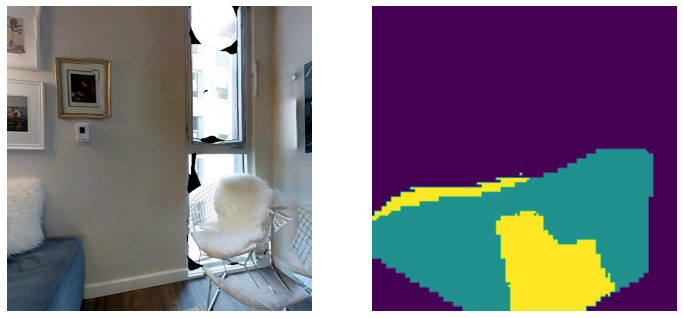

In [120]:
save_path = '/scratch/shantanu/iros_video/src_videos/denmark/rgb.mp4'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

save_video(rgb_dir, save_path)


In [36]:
scenes = os.listdir('/scratch/shantanu/final_results/gibson4/weights_90')

for scene in scenes:
    save_path = f'/scratch/shantanu/iros_video/src_videos/rgb/{scene}.mp4'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    save_video(f'/scratch/shantanu/gibson4/new/{scene}/0/front/RGB', save_path)


t:  51%|███████████████████████████████████████████▎                                         | 402/789 [1:35:03<00:02, 153.09it/s, now=None]

99 19
Moviepy - Building video /scratch/shantanu/iros_video/src_videos/rgb/Pablo.mp4.
Moviepy - Writing video /scratch/shantanu/iros_video/src_videos/rgb/Pablo.mp4




t:  51%|███████████████████████████████████████████▎                                         | 402/789 [1:35:05<00:02, 153.09it/s, now=None]

Moviepy - Done !
Moviepy - video ready /scratch/shantanu/iros_video/src_videos/rgb/Pablo.mp4
113 22
Moviepy - Building video /scratch/shantanu/iros_video/src_videos/rgb/Elmira.mp4.
Moviepy - Writing video /scratch/shantanu/iros_video/src_videos/rgb/Elmira.mp4




t:  51%|███████████████████████████████████████████▎                                         | 402/789 [1:35:07<00:02, 153.09it/s, now=None]

Moviepy - Done !
Moviepy - video ready /scratch/shantanu/iros_video/src_videos/rgb/Elmira.mp4
87 17
Moviepy - Building video /scratch/shantanu/iros_video/src_videos/rgb/Sisters.mp4.
Moviepy - Writing video /scratch/shantanu/iros_video/src_videos/rgb/Sisters.mp4




t:  51%|███████████████████████████████████████████▎                                         | 402/789 [1:35:09<00:02, 153.09it/s, now=None]

Moviepy - Done !
Moviepy - video ready /scratch/shantanu/iros_video/src_videos/rgb/Sisters.mp4
116 23
Moviepy - Building video /scratch/shantanu/iros_video/src_videos/rgb/Eudora.mp4.
Moviepy - Writing video /scratch/shantanu/iros_video/src_videos/rgb/Eudora.mp4




t:  51%|███████████████████████████████████████████▎                                         | 402/789 [1:35:11<00:02, 153.09it/s, now=None]

Moviepy - Done !
Moviepy - video ready /scratch/shantanu/iros_video/src_videos/rgb/Eudora.mp4
143 28
Moviepy - Building video /scratch/shantanu/iros_video/src_videos/rgb/Ribera.mp4.
Moviepy - Writing video /scratch/shantanu/iros_video/src_videos/rgb/Ribera.mp4




t:  51%|███████████████████████████████████████████▎                                         | 402/789 [1:35:14<00:02, 153.09it/s, now=None]

Moviepy - Done !
Moviepy - video ready /scratch/shantanu/iros_video/src_videos/rgb/Ribera.mp4
106 21
Moviepy - Building video /scratch/shantanu/iros_video/src_videos/rgb/Denmark.mp4.
Moviepy - Writing video /scratch/shantanu/iros_video/src_videos/rgb/Denmark.mp4




t:  51%|███████████████████████████████████████████▎                                         | 402/789 [1:35:17<00:02, 153.09it/s, now=None]

Moviepy - Done !
Moviepy - video ready /scratch/shantanu/iros_video/src_videos/rgb/Denmark.mp4
264 52
Moviepy - Building video /scratch/shantanu/iros_video/src_videos/rgb/Swormville.mp4.
Moviepy - Writing video /scratch/shantanu/iros_video/src_videos/rgb/Swormville.mp4




t:  51%|███████████████████████████████████████████▎                                         | 402/789 [1:35:22<00:02, 153.09it/s, now=None]

Moviepy - Done !
Moviepy - video ready /scratch/shantanu/iros_video/src_videos/rgb/Swormville.mp4
509 101
Moviepy - Building video /scratch/shantanu/iros_video/src_videos/rgb/Cantwell.mp4.
Moviepy - Writing video /scratch/shantanu/iros_video/src_videos/rgb/Cantwell.mp4




t:  51%|███████████████████████████████████████████▎                                         | 402/789 [1:35:34<00:02, 153.09it/s, now=None]

Moviepy - Done !
Moviepy - video ready /scratch/shantanu/iros_video/src_videos/rgb/Cantwell.mp4
821 164
Moviepy - Building video /scratch/shantanu/iros_video/src_videos/rgb/Mosquito.mp4.
Moviepy - Writing video /scratch/shantanu/iros_video/src_videos/rgb/Mosquito.mp4




t:  85%|██████████████████████████████████████████████████████████████████████████▌             | 695/820 [00:12<00:02, 52.67it/s, now=None]


t:  51%|███████████████████████████████████████████▎                                         | 402/789 [1:35:49<00:02, 153.09it/s, now=None]

Moviepy - Done !
Moviepy - video ready /scratch/shantanu/iros_video/src_videos/rgb/Mosquito.mp4
422 84
Moviepy - Building video /scratch/shantanu/iros_video/src_videos/rgb/Scioto.mp4.
Moviepy - Writing video /scratch/shantanu/iros_video/src_videos/rgb/Scioto.mp4




t:  51%|███████████████████████████████████████████▎                                         | 402/789 [1:35:58<00:02, 153.09it/s, now=None]

Moviepy - Done !
Moviepy - video ready /scratch/shantanu/iros_video/src_videos/rgb/Scioto.mp4
75 15
Moviepy - Building video /scratch/shantanu/iros_video/src_videos/rgb/Edgemere.mp4.
Moviepy - Writing video /scratch/shantanu/iros_video/src_videos/rgb/Edgemere.mp4




t:  51%|███████████████████████████████████████████▎                                         | 402/789 [1:35:59<00:02, 153.09it/s, now=None]

Moviepy - Done !
Moviepy - video ready /scratch/shantanu/iros_video/src_videos/rgb/Edgemere.mp4
244 48
Moviepy - Building video /scratch/shantanu/iros_video/src_videos/rgb/Eastville.mp4.
Moviepy - Writing video /scratch/shantanu/iros_video/src_videos/rgb/Eastville.mp4




t:  51%|███████████████████████████████████████████▎                                         | 402/789 [1:36:05<00:02, 153.09it/s, now=None]

Moviepy - Done !
Moviepy - video ready /scratch/shantanu/iros_video/src_videos/rgb/Eastville.mp4
18 3
Moviepy - Building video /scratch/shantanu/iros_video/src_videos/rgb/Sands.mp4.
Moviepy - Writing video /scratch/shantanu/iros_video/src_videos/rgb/Sands.mp4




t:  51%|███████████████████████████████████████████▎                                         | 402/789 [1:36:05<00:02, 153.09it/s, now=None]

Moviepy - Done !
Moviepy - video ready /scratch/shantanu/iros_video/src_videos/rgb/Sands.mp4
119 23
Moviepy - Building video /scratch/shantanu/iros_video/src_videos/rgb/Greigsville.mp4.
Moviepy - Writing video /scratch/shantanu/iros_video/src_videos/rgb/Greigsville.mp4




t:  51%|███████████████████████████████████████████▎                                         | 402/789 [1:36:08<00:02, 153.09it/s, now=None]

Moviepy - Done !
Moviepy - video ready /scratch/shantanu/iros_video/src_videos/rgb/Greigsville.mp4


## Overlay bev on rgb for Lab dataset

In [98]:
# K = np.array([378.47052001953125, 0.0, 318.99395751953125, 
#               0.0, 378.2340087890625, 253.28782653808594, 
#               0.0, 0.0, 1.0]).reshape((3,3))

K = np.array([384.38043212890625, 0.0, 320.305419921875, 
              0.0, 384.38043212890625, 237.7599639892578, 
              0.0, 0.0, 1.0]).reshape((3,3))

In [99]:
# K = np.array([256, 0, 256, 0, 256, 256, 0, 0, 1]).reshape((3,3))

# K = np.array([403.7, 0, 340.26, 0, 403.7, 270.173, 0, 0, 1]).reshape((3,3))  # At (682.67, 512)
K = np.array([403.7, 0, 254.925, 0, 403.7, 270.173, 0, 0, 1]).reshape((3,3))  # At (512, 512)

In [104]:
idx = 0

rgb = cv2.cvtColor(cv2.imread(f'/scratch/shantanu/iros_video/rgb_images1/frame{idx}.jpg', -1), cv2.COLOR_BGR2RGB)
depth = np.load(f'/scratch/shantanu/iros_video/depth_images1/dframe{idx}.npy').astype(np.float32)/1000

bev = cv2.imread(f'/scratch/shantanu/iros_video/output1/basic_transformer/pred/frame{idx}.png', -1)

In [105]:
idx = 164630169835

rgb = cv2.cvtColor(cv2.imread(f'/scratch/shantanu/iros_video/new/rgb_frames/frame{idx}.jpg', -1), cv2.COLOR_BGR2RGB)
depth = np.load(f'/scratch/shantanu/iros_video/new/depth_frames/dframe{idx}.npy').astype(np.float32)/1000

bev = cv2.imread(f'/scratch/shantanu/iros_video/output2/basic_transformer/pred/{idx}.png', -1)

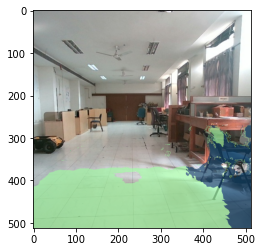

In [106]:
crop = A.Compose([
    A.augmentations.geometric.resize.SmallestMaxSize(max_size=512, interpolation=cv2.INTER_CUBIC, always_apply=True),
    A.augmentations.crops.transforms.CenterCrop(512, 512, always_apply=True),
])

rgb = crop(image=rgb)['image']
depth = crop(image=depth)['image']

seg = get_seg_map(depth, bev, K)
plt.imshow(seg)

rgb_overlay = rgb.copy()
# rgb_overlay[seg==0] = (1*rgb_overlay[seg==0] + clist[0]) // 2
rgb_overlay[seg==127] = (1*rgb_overlay[seg==127] + 2*clist[1]) // 3
rgb_overlay[seg==254] = (1*rgb_overlay[seg==254] + 2*clist[2]) // 3

rgb_overlay = rgb_overlay.astype(np.uint8)

plt.imshow(rgb_overlay)

In [67]:
def save_video(data_dir, save_path):
    filenames = sorted([x for x in os.listdir(data_dir) if os.path.splitext(x)[1] == '.jpg'], 
                       key=lambda x: int(os.path.splitext(x)[0].replace('frame', '')))
    filepaths = [os.path.join(data_dir, x) for x in filenames][175:]
    num_frames = len(filepaths)
    fps = 5
    duration = num_frames // fps
    print(num_frames, duration)
    tgt_shape = 512

    def get_frame(t):            
        idx = int(t * fps)
        
        rgb = cv2.cvtColor(cv2.imread(f'/scratch/shantanu/iros_video/rgb_images1/frame{idx}.jpg', -1), cv2.COLOR_BGR2RGB)
        depth = np.load(f'/scratch/shantanu/iros_video/depth_images1/dframe{idx}.npy').astype(np.float32)/1000

        bev = cv2.imread(f'/scratch/shantanu/iros_video/output1/basic_transformer/pred/frame{idx}.png', -1)
        
        crop = A.Compose([
            A.augmentations.geometric.resize.SmallestMaxSize(max_size=512, interpolation=cv2.INTER_CUBIC, always_apply=True),
            A.augmentations.crops.transforms.CenterCrop(512, 512, always_apply=True),
        ])
        
        rgb = crop(image=rgb)['image']
        depth = crop(image=depth)['image']

#         h, w, c = rgb.shape

#         sx, sy = (w - tgt_shape)//2, (h - tgt_shape)//2

#         rgb = rgb[sy:sy+tgt_shape, sx:sx+tgt_shape,:]
#         depth = depth[sy:sy+tgt_shape, sx:sx+tgt_shape]
        
        seg = get_seg_map(depth, bev, K)

        rgb_overlay = rgb.copy()
        # rgb_overlay[seg==0] = (1*rgb_overlay[seg==0] + clist[0]) // 2
        rgb_overlay[seg==127] = (1*rgb_overlay[seg==127] + 2*clist[1]) // 3
        rgb_overlay[seg==254] = (1*rgb_overlay[seg==254] + 2*clist[2]) // 3

        rgb_overlay = rgb_overlay.astype(np.uint8)

        return rgb_overlay


    animation = VideoClip(get_frame, duration = duration)
    animation.write_videofile(save_path, fps=fps)

In [68]:
save_video('/scratch/shantanu/iros_video/rgb_images1', '/scratch/shantanu/iros_video/overlay3.mp4')

949 189
Moviepy - Building video /scratch/shantanu/iros_video/overlay3.mp4.
Moviepy - Writing video /scratch/shantanu/iros_video/overlay3.mp4



Moviepy - Done !
Moviepy - video ready /scratch/shantanu/iros_video/overlay3.mp4


In [55]:
np.rad2deg(np.arctan2(640, (2*378.47052001953125)) * 2)

80.42959983194228

In [54]:
np.rad2deg(np.arctan2(480, (2*378.47052001953125)) * 2)

64.76012550456853

In [58]:
np.rad2deg(np.arctan2(1511, (4*378.47052001953125)) * 2)

89.89081823994816

In [59]:
64.76012550456853/2

32.38006275228427

In [102]:
def save_video(rgb_dir, depth_dir, save_path):
    filenames = sorted([x for x in os.listdir(rgb_dir) if os.path.splitext(x)[1] == '.jpg'], 
                       key=lambda x: int(os.path.splitext(x)[0].replace('frame', '')))    
    
    depth_filenames = sorted([x for x in os.listdir(depth_dir) if os.path.splitext(x)[1] == '.npy'], 
                       key=lambda x: int(os.path.splitext(x)[0].replace('dframe', '')))
    
    num_frames = len(filenames)
    fps = 5
    duration = num_frames // fps
    print(num_frames, duration)
    tgt_shape = 512

    def get_frame(t):            
        idx = int(t * fps)
        
        rgb_filename = filenames[idx]
        bev_filename = rgb_filename.replace('.jpg', '.png').replace('frame', '')
        
        dist = [abs(int(os.path.splitext(x)[0].replace('dframe', '')) -
                    int(os.path.splitext(rgb_filename)[0].replace('frame', ''))) for x in depth_filenames]
        idx = np.argmin(dist)
        depth_filename = depth_filenames[idx]
        
        rgb = cv2.cvtColor(cv2.imread(f'/scratch/shantanu/iros_video/new/rgb_frames/{rgb_filename}', -1), cv2.COLOR_BGR2RGB)
        depth = np.load(f'/scratch/shantanu/iros_video/new/depth_frames/{depth_filename}').astype(np.float32)/1000

        bev = cv2.imread(f'/scratch/shantanu/iros_video/output2/basic_transformer/pred/{bev_filename}', -1)
        
        crop = A.Compose([
            A.augmentations.geometric.resize.SmallestMaxSize(max_size=512, interpolation=cv2.INTER_CUBIC, always_apply=True),
            A.augmentations.crops.transforms.CenterCrop(512, 512, always_apply=True),
        ])
        
        rgb = crop(image=rgb)['image']
        depth = crop(image=depth)['image']

#         h, w, c = rgb.shape

#         sx, sy = (w - tgt_shape)//2, (h - tgt_shape)//2

#         rgb = rgb[sy:sy+tgt_shape, sx:sx+tgt_shape,:]
#         depth = depth[sy:sy+tgt_shape, sx:sx+tgt_shape]
        
        seg = get_seg_map(depth, bev, K)

        rgb_overlay = rgb.copy()
        # rgb_overlay[seg==0] = (1*rgb_overlay[seg==0] + clist[0]) // 2
        rgb_overlay[seg==127] = (1*rgb_overlay[seg==127] + 2*clist[1]) // 3
        rgb_overlay[seg==254] = (1*rgb_overlay[seg==254] + 2*clist[2]) // 3

        rgb_overlay = rgb_overlay.astype(np.uint8)

        return rgb_overlay


    animation = VideoClip(get_frame, duration = duration)
    animation.write_videofile(save_path, fps=fps)

In [103]:
save_video('/scratch/shantanu/iros_video/new/rgb_frames', 
           '/scratch/shantanu/iros_video/new/depth_frames',
           '/scratch/shantanu/iros_video/overlay4.mp4')

t:   3%|██▊                                                                                     | 36/1130 [33:06<03:27,  5.27it/s, now=None]

1133 226
Moviepy - Building video /scratch/shantanu/iros_video/overlay4.mp4.
Moviepy - Writing video /scratch/shantanu/iros_video/overlay4.mp4




t:   5%|████▍                                                                                   | 57/1130 [00:09<03:03,  5.85it/s, now=None]


t:  10%|████████▋                                                                              | 113/1130 [00:18<02:42,  6.25it/s, now=None]


t:  15%|█████████████                                                                          | 169/1130 [00:28<02:41,  5.94it/s, now=None]


t:  20%|█████████████████▎                                                                     | 225/1130 [00:37<02:34,  5.87it/s, now=None]


t:  25%|█████████████████████▋                                                                 | 281/1130 [00:47<02:19,  6.09it/s, now=None]


t:  30%|█████████████████████████▉                                                             | 337/1130 [00:56<02:16,  5.83it/s, now=None]


t:  35%|██████████████████████████████▍                                                        | 396/1130 [01:04<01:31,  8.01it/s, now=None]


t:  41%|███████████████████████████████████▋                                                   | 464/1130 [01:12<01:49,  6.07it/s, now=None]


t:  47%|████████████████████████████████████████▋                                              | 529/1130 [01:20<01:01,  9.81it/s, now=None]


t:  52%|█████████████████████████████████████████████▎                                         | 589/1130 [01:28<01:36,  5.62it/s, now=None]


t:  57%|█████████████████████████████████████████████████▋                                     | 645/1130 [01:38<01:18,  6.15it/s, now=None]


t:  62%|█████████████████████████████████████████████████████▉                                 | 701/1130 [01:48<01:03,  6.79it/s, now=None]


t:  67%|██████████████████████████████████████████████████████████▎                            | 757/1130 [01:57<01:01,  6.11it/s, now=None]


t:  72%|██████████████████████████████████████████████████████████████▌                        | 813/1130 [02:06<00:53,  5.90it/s, now=None]


t:  77%|██████████████████████████████████████████████████████████████████▉                    | 869/1130 [02:16<00:42,  6.12it/s, now=None]


t:  82%|███████████████████████████████████████████████████████████████████████▏               | 925/1130 [02:26<00:35,  5.75it/s, now=None]


t:  87%|███████████████████████████████████████████████████████████████████████████▌           | 981/1130 [02:35<00:25,  5.86it/s, now=None]


t:  92%|██████████████████████████████████████████████████████████████████████████████▉       | 1037/1130 [02:44<00:15,  5.99it/s, now=None]


t:  97%|███████████████████████████████████████████████████████████████████████████████████▏  | 1093/1130 [02:53<00:05,  6.66it/s, now=None]


t:   3%|██▊                                                                                     | 36/1130 [36:06<03:27,  5.27it/s, now=None]

Moviepy - Done !
Moviepy - video ready /scratch/shantanu/iros_video/overlay4.mp4
